# Comparing importance scores with metrics like correlation & JSD

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm

import sys
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA/')
from plotting_helper import *
from all_functions import *
from profile_models import ModelLoader
import profile_performance
from profile_performance import *

tqdm.tqdm_notebook()

plt.rcParams["figure.dpi"] = 130

/tmp/ipykernel_71690/982504472.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [31]:
# load in importance scores
act_scores = pickle.load(open('/home/katie/bp_repo/reports/katie_notebooks/june2022_analysis/act_scores.dict', 'rb'))
hyp_scores = pickle.load(open('/home/katie/bp_repo/reports/katie_notebooks/june2022_analysis/hyp_scores.dict', 'rb'))

In [3]:
keys = list(act_scores.keys())
key_pairs = [ ('CTCF_chip_model_shared_chip_loader_fake_controls', 'CTCF_cut_model_shared_chip_loader'),
              ('CTCF_chip_model_shared_cut_loader_fake_controls', 'CTCF_cut_model_shared_cut_loader'),
              ('CTCF_chip_model_unique_chip_loader_fake_controls', 'CTCF_cut_model_unique_chip_loader'),
              ('CTCF_chip_model_unique_cut_loader_fake_controls', 'CTCF_cut_model_unique_cut_loader'),
              ('FOSL2_chip_model_shared_chip_loader_fake_controls', 'FOSL2_cut_model_shared_chip_loader'),
              ('FOSL2_chip_model_shared_cut_loader_fake_controls', 'FOSL2_cut_model_shared_cut_loader'),
              ('FOSL2_chip_model_unique_chip_loader_fake_controls', 'FOSL2_cut_model_unique_chip_loader'),
              ('FOSL2_chip_model_unique_cut_loader_fake_controls', 'FOSL2_cut_model_unique_cut_loader')]

In [138]:
subsets = ['CTCF shared ChIP-seq peaks', 'CTCF shared CUT&RUN peaks', 'CTCF unique ChIP-seq peaks', 'CTCF unique CUT&RUN peaks',
           'FOSL2 shared ChIP-seq peaks', 'FOSL2 shared CUT&RUN peaks', 'FOSL2 unique ChIP-seq peaks', 'FOSL2 unique CUT&RUN peaks']
metrics = ['Pearson on act scores', 'JSD on act scores', 'Continuous Jaccard similarity on hyp scores', 'Pearson on hyp scores', 'JSD on hyp scores']

## Pearson on *actual* importance scores

In [32]:
# actual scores have 3 0's and 1 non-zero value for each base position, so we sum across this axis to 
# just keep that single non-zero value
for key in keys:
    act_scores[key] = np.sum(act_scores[key], axis=2)  

In [61]:
# now we run the pearson_corr function, which computes correlation across this last dimension
pearson_act_scores = {}
for key in key_pairs:
    pearson_act_scores[key] = pearson_corr(act_scores[key[0]], act_scores[key[1]])

Text(0.5, 1.0, 'Pearson on act scores')

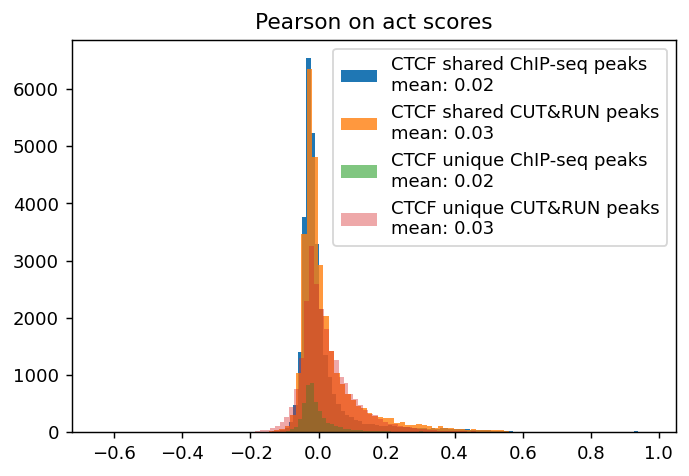

In [184]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(pearson_act_scores[key_pairs[i]]), 2)
    plt.hist(pearson_act_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[0])

Text(0.5, 1.0, 'Pearson on act scores')

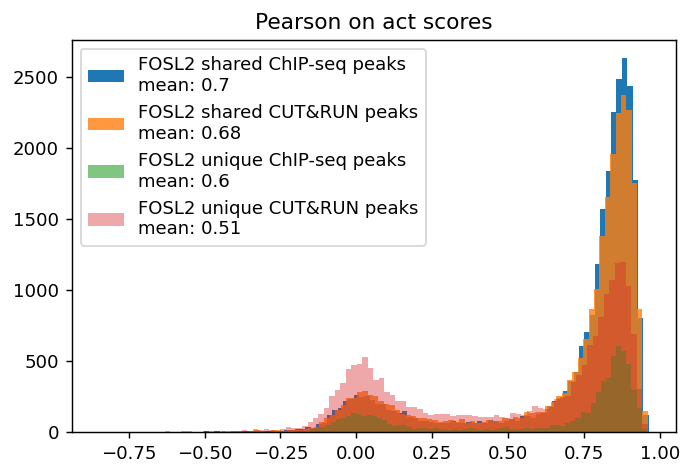

In [183]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(pearson_act_scores[key_pairs[i]]), 2)
    plt.hist(pearson_act_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[0])

## JSD on *actual* importance scores

In [83]:
# now we run the jensen_shannon_distance function, which computes JSD across this last dimension
# n.b. we must take the absolute value of everything before computing JSD!!
jsd_act_scores = {}
for key in key_pairs:
    jsd_act_scores[key] = jensen_shannon_distance(np.abs(act_scores[key[0]]), np.abs(act_scores[key[1]]))

Text(0.5, 1.0, 'JSD on act scores')

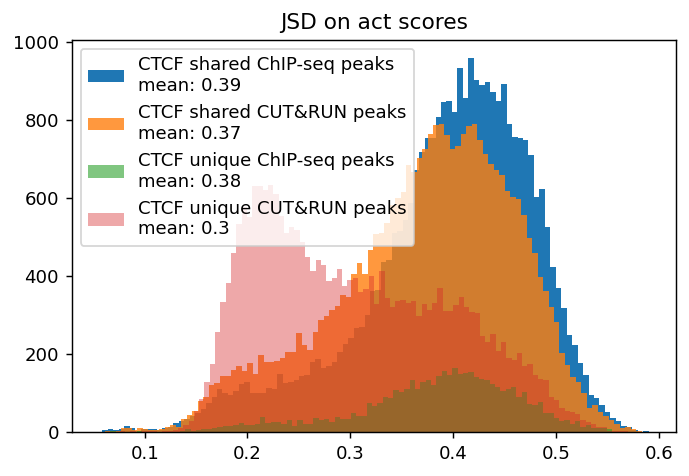

In [182]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(jsd_act_scores[key_pairs[i]]), 2)
    plt.hist(jsd_act_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[1])

Text(0.5, 1.0, 'JSD on act scores')

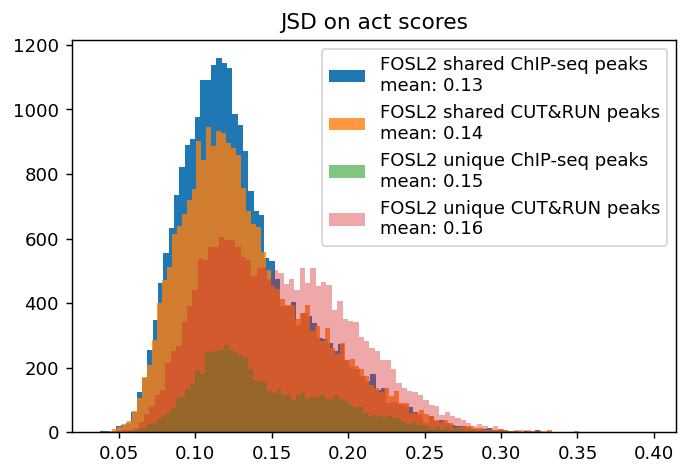

In [181]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(jsd_act_scores[key_pairs[i]]), 2)
    plt.hist(jsd_act_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[1])

## Continuous jaccard similarity on *hypothetical* importance scores

In [17]:
def cont_jaccard(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a continuous Jaccard metric.
    """
    # L1-normalize
    norm_1 = np.sum(np.abs(seq_1), axis=1, keepdims=True)
    norm_2 = np.sum(np.abs(seq_2), axis=1, keepdims=True)
    norm_1[norm_1 == 0] = 1
    norm_2[norm_2 == 0] = 1
    seq_1 = seq_1 / norm_1
    seq_2 = seq_2 / norm_2
    
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.sum(np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2), axis=1)
    union = np.sum(np.maximum(ab_1, ab_2), axis=1)
    zero_mask = union == 0
    inter[zero_mask] = 0
    union[zero_mask] = 1
    return np.sum(inter / union)

In [117]:
jaccard_hyp_scores = {}
for key in key_pairs:
    jaccard_hyp_scores[key] = list(cont_jaccard( hyp_scores[key[0]][i], hyp_scores[key[1]][i] ) for i in range(len(hyp_scores[key[0]])))

Text(0.5, 1.0, 'Continuous Jaccard similarity on hyp scores')

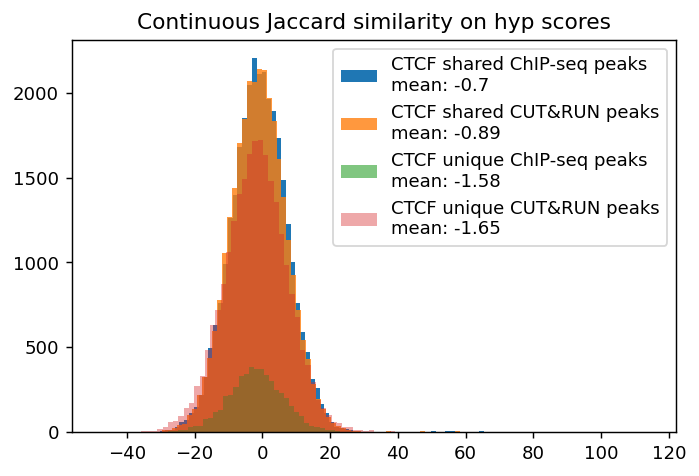

In [180]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(jaccard_hyp_scores[key_pairs[i]]), 2)
    plt.hist(jaccard_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[2])

Text(0.5, 1.0, 'Continuous Jaccard similarity on hyp scores')

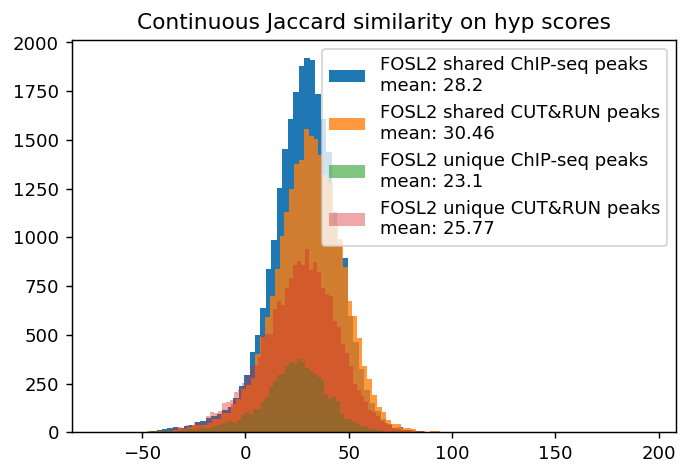

In [179]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(jaccard_hyp_scores[key_pairs[i]]), 2)
    plt.hist(jaccard_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[2])

## Pearson on *hypothetical* importance scores

In [142]:
# to do stuff on hyp scores, we need to flatten the last two dimensions (400 x 4) into one dimension (1600)
for key in keys:
    hyp_scores[key] = hyp_scores[key].reshape((-1, 1600))

In [143]:
# now we run the pearson_corr function, which computes correlation across this last dimension
pearson_hyp_scores = {}
for key in key_pairs:
    pearson_hyp_scores[key] = pearson_corr(hyp_scores[key[0]], hyp_scores[key[1]])

Text(0.5, 1.0, 'Pearson on hyp scores')

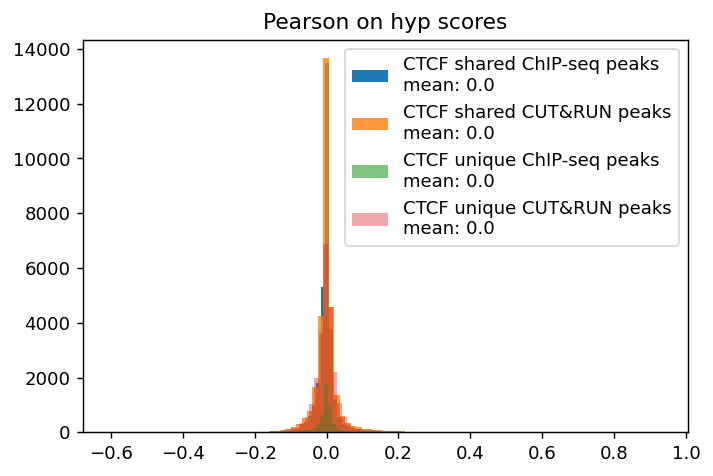

In [178]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(pearson_hyp_scores[key_pairs[i]]), 2)
    plt.hist(pearson_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[3])

Text(0.5, 1.0, 'Pearson on hyp scores')

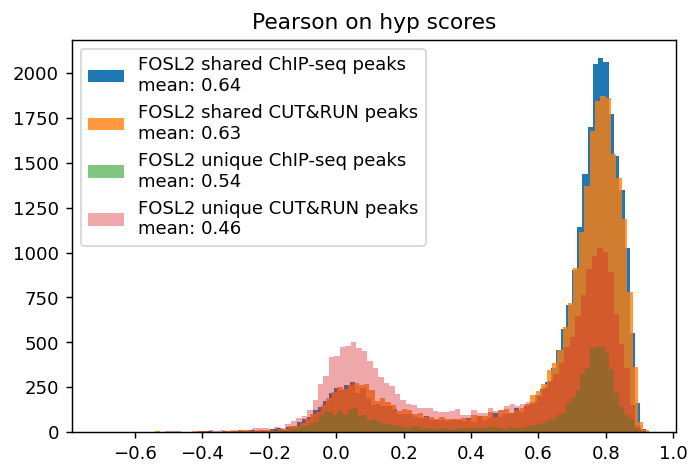

In [173]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(pearson_hyp_scores[key_pairs[i]]), 2)
    plt.hist(pearson_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[3])

## JSD on *hypothetical* importance scores

In [147]:
# now we run the jensen_shannon_distance function, which computes JSD across this last dimension
# n.b. we must take the absolute value of everything before computing JSD!!
jsd_hyp_scores = {}
for key in key_pairs:
    jsd_hyp_scores[key] = jensen_shannon_distance(np.abs(hyp_scores[key[0]]), np.abs(hyp_scores[key[1]]))

Text(0.5, 1.0, 'JSD on hyp scores')

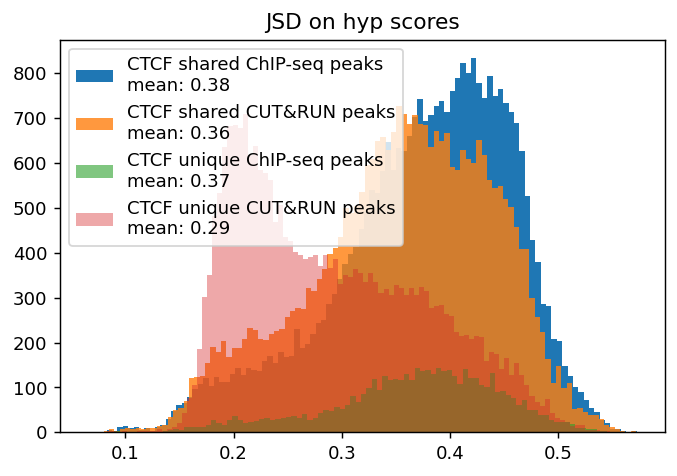

In [176]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for i in range(4):
    mean = np.round(np.mean(jsd_hyp_scores[key_pairs[i]]), 2)
    plt.hist(jsd_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*i, label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[4])

Text(0.5, 1.0, 'JSD on hyp scores')

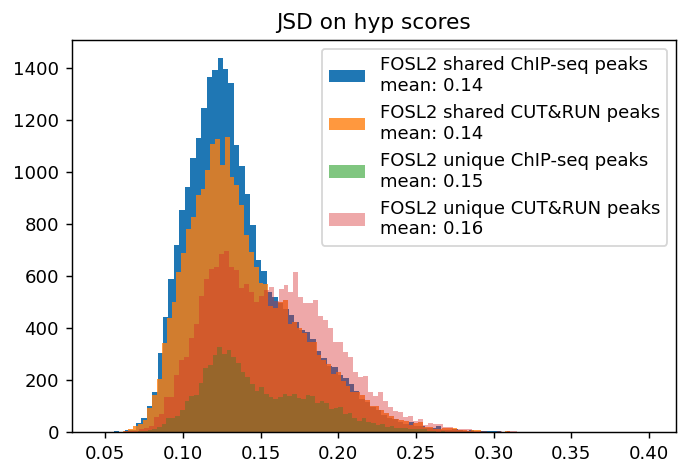

In [177]:
# plot distribution of correlations (across each FOSL2 subset)
fig = plt.figure()
for i in range(4,8):
    mean = np.round(np.mean(jsd_hyp_scores[key_pairs[i]]), 2)
    plt.hist(jsd_hyp_scores[key_pairs[i]], bins=100, alpha=1-0.2*(i-4), label=f'{subsets[i]}\nmean: {mean}')
plt.legend()
plt.title(metrics[4])